In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2

In [3]:
train_path = "E:\\College\\Sem 7\\DL\\DL lab\\datasets\\training_set\\training_set"
train_data = Path(train_path)

test_path = "E:\\College\\Sem 7\\DL\\DL lab\\datasets\\test_set\\test_set"
test_data = Path(test_path)

In [4]:
train_animals = {
    'dog': list(train_data.glob('dogs/*.*')),
    'cat': list(train_data.glob('cats/*.*'))
}
labels = {
    'dog' : 1,
    'cat' : 0
}

In [5]:
from sklearn.model_selection import train_test_split

image_paths = []
image_labels = []

for name, images in train_animals.items():
    for image in images:
        image_paths.append(str(image))
        image_labels.append(labels[name])

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, image_labels, test_size=0.15, stratify=image_labels, random_state=42)

In [6]:
def path_to_images(paths, labels, batch_size):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            images = []
            for path in batch_paths:
                img = cv2.imread(path)  
                if img is not None:
                    img = cv2.resize(img, (224, 224))  
                    images.append(img)
                else:
                    images.append(np.zeros((224, 224, 3))) 

            images = np.array(images)
            batch_labels = np.array(batch_labels).reshape(-1, 1) 
            yield images, batch_labels


batch_size = 16

train_generator = path_to_images(train_paths, train_labels, batch_size)
val_generator = path_to_images(val_paths, val_labels, batch_size)

In [7]:
print(f"Total number of images in train set: {len(train_paths)}")
print(f"Total number of images in validation set: {len(val_paths)}")

Total number of images in train set: 6804
Total number of images in validation set: 1201


In [8]:
def print_label_distribution(labels, dataset_name):
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print(f"Label distribution in {dataset_name}:")
    for label, count in label_distribution.items():
        print(f"Label {label}: {count} samples")
    print("\n")

# Check diversity of labels in train, validation, and test sets
print_label_distribution(train_labels, "Training Set")
print_label_distribution(val_labels, "Validation Set")

Label distribution in Training Set:
Label 0: 3400 samples
Label 1: 3404 samples


Label distribution in Validation Set:
Label 0: 600 samples
Label 1: 601 samples




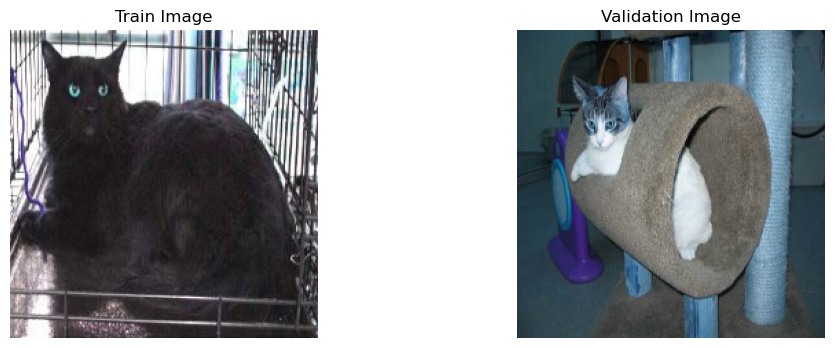

In [9]:
import matplotlib.pyplot as plt

def get_first_image(generator):
    images, labels = next(generator)  
    first_image = images[0]  
    return first_image

first_train_image = get_first_image(train_generator)
first_val_image = get_first_image(val_generator)

# Function to display images side by side
def display_images_side_by_side(images, titles):
    plt.figure(figsize=(12, 4))
    
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(titles[i])
        plt.axis('off')
    
    plt.show()

images = [first_train_image, first_val_image]
titles = ['Train Image', 'Validation Image']

display_images_side_by_side(images, titles)

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = models.Sequential([
    base_model,  # Pre-trained VGG16 without the top layers
    layers.Flatten(),  # Flatten the output of the convolutional base
    layers.Dense(256, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Binary output layer for cats/dogs
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 13,502,465 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [11]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(val_paths) // batch_size

# Train the model with steps specified
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5, 
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 1815s 4s/step - accuracy: 0.8630 - loss: 1.0679 - val_accuracy: 0.9747 - val_loss: 0.0804
Epoch 2/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 815s 2s/step - accuracy: 0.9683 - loss: 0.1012 - val_accuracy: 0.9750 - val_loss: 0.0929
Epoch 3/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.9759 - loss: 0.0689 - val_accuracy: 0.9789 - val_loss: 0.0745
Epoch 4/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.9869 - loss: 0.0380 - val_accuracy: 0.9722 - val_loss: 0.1060
Epoch 5/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.9904 - loss: 0.0241 - val_accuracy: 0.9696 - val_loss: 0.0889


In [12]:
test_animals = {
    'dog': list(test_data.glob('dogs/*.*')),
    'cat': list(test_data.glob('cats/*.*'))
}
test_labels = {
    'dog' : 1,
    'cat' : 0
}

In [13]:
from sklearn.model_selection import train_test_split

# Assuming 'animals' contains the file paths as you already have
image_paths = []
image_labels = []

for name, images in test_animals.items():
    for image in images:
        image_paths.append(str(image))
        image_labels.append(test_labels[name])  # 1 for dog, 0 for cat

# Convert to NumPy arrays
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

In [14]:
test_generator = path_to_images(image_paths, image_labels, batch_size)

In [15]:
predictions = model.predict(test_generator, steps=len(image_paths) // batch_size + 1, verbose=1)

predicted_labels = (predictions > 0.5).astype(int)

predicted_labels = predicted_labels[:len(image_paths)]

127/127 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = []
for _, labels in test_generator:
    true_labels.extend(labels)
    if len(true_labels) >= len(image_paths):
        break

true_labels = np.array(true_labels[:len(image_paths)]).flatten()

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:\n", conf_matrix)

print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=['cat', 'dog']))

Confusion Matrix:
 [[946  65]
 [ 32 980]]
Classification Report:
               precision    recall  f1-score   support

         cat       0.97      0.94      0.95      1011
         dog       0.94      0.97      0.95      1012

    accuracy                           0.95      2023
   macro avg       0.95      0.95      0.95      2023
weighted avg       0.95      0.95      0.95      2023



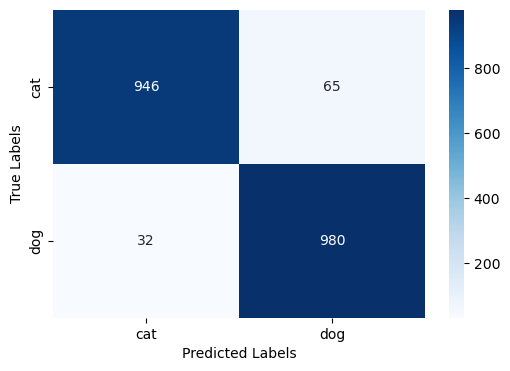

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()